# Statistical Modeling of the Gutenberg–Richter Law in Earthquake Data

### *Introduction*: 
According to the Gutenberg-Richter frequency magnitude relation [1], the number of earthquakes N, having a magnitude equal to or larger than M, can be expressed by the equation  


$$log_{10}(N) = a - b*M$$  

where $a$ is a measure of the level of seismicity and $b$ describes the ration between the number of small and large events. The Gutenberg–Richter relation is of significant importance to seismic studies because it is used to
describe both tectonic and induced seismicity, can be applied
in different time scales, and holds true over a large interval of
earthquake magnitudes.  

From the law, the number of events falls off exponentially with magnitude. That is:  

$$\frac{N(M_1)}{N(M_2)} = 10^{b(M_2 - M_1)}$$

This gives a very intuitive interpretation. Lower b-values correspond to relatively more large earthquakes, which can be indicative of different tectonic behaviors or stress regimes. For example, with $b=1$, for every 100 earthquakes of magnitude 3, you expect 10 of magnitude 4, and 1 of magnitude 5.
With $b=0.5$, for every 100 magnitude 3 earthquakes, you'd expect ~31 of magnitude 4, and ~10 of magnitude 5.
With $b=1.5$, the drop is even steeper: only about 3 magnitude 4s per 100 magnitude 3s.  

This project will analyze the Gutenberg–Richter frequency–magnitude relationship using earthquake data from California, attempt to fit a suitable b-value using an MLE approach and a Bayesian one, then use data from Japan as a seismologically active region to perform Extreme Value analysis.




#### *Data preprocessing*

In [498]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import missingno as msn
import numpy as np 
import math 
from seismostats import Catalog

In [499]:
df = pd.read_csv("data/california.csv")
df.sample(3)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
14002,2019-01-07T01:04:14.150Z,36.587500,-121.185000,3.540,2.56,md,48.0,83.0,0.01577,0.08,...,2019-03-20T01:30:27.300Z,"7km NNW of Pinnacles, CA",earthquake,0.17,0.22,0.186,49.0,reviewed,nc,nc
5326,2021-06-14T20:18:12.060Z,31.485100,-115.641700,5.000,2.50,ml,NaN,109.0,0.15300,0.94,...,2021-08-26T21:59:20.040Z,"60 km ENE of San Vicente, Mexico",earthquake,2.20,2.00,0.060,36.0,reviewed,us,us
18562,2015-07-28T20:12:11.330Z,41.985667,-120.153167,5.407,2.73,ml,14.0,119.0,0.13960,0.04,...,2018-06-29T23:58:50.877Z,"11 km E of New Pine Creek, California",earthquake,0.28,0.82,0.106,5.0,reviewed,nc,nc


##### *Magnitude types* 

Earthquake size, as measured by the Richter Scale is a well known, but not well understood, concept. The idea of a logarithmic earthquake magnitude scale was first developed by Charles Richter in the 1930's for measuring the size of earthquakes occurring in southern California using relatively high-frequency data from nearby seismograph stations. This magnitude scale was referred to as ML, with the L standing for local. This is what was to eventually become known as the Richter magnitude.

As more seismograph stations were installed around the world, it became apparent that the method developed by Richter was strictly valid only for certain frequency and distance ranges. In order to take advantage of the growing number of globally distributed seismograph stations, new magnitude scales that are an extension of Richter's original idea were developed. These include body wave magnitude (Mb) and surface wave magnitude (Ms). Each is valid for a particular frequency range and type of seismic signal. **In its range of validity, each is equivalent to the Richter magnitude.**

Magnitude scales differ based on both physical instrumentation and the seismic frequencies they capture. Local magnitude (ML) and duration magnitude (Md), derived from Wood–Anderson–equivalent seismographs and shaking duration, are abundant in the California dataset due to dense local monitoring and focus on small earthquakes. In contrast, the Japan dataset primarily uses body-wave (mb) and moment magnitudes (Mw, Mwr, Mwc), which are more reliable for larger events and less affected by saturation, making it more suitable for extreme value modeling. This is also the main reason why the California dataset encompasses small to moderate earthquakes, while the Japan dataset only considers earthquakes with a magnitude of 4.0+, with a maximum magnitude recorded of 9.1. 

In [500]:
df["magType"].value_counts()

magType
ml     14059
md      2988
mw       936
mb       271
mlr      264
mwr      218
mww       62
mh        36
mc         3
mwc        1
Name: count, dtype: int64

In [501]:
df["time"] = pd.to_datetime(df["time"]) # Transform time column to hold Pandas DateTime objects 
df.drop_duplicates(inplace=True) # Drop duplicates if any exist 

In [502]:
df.isnull().sum()

time                  0
latitude              0
longitude             0
depth                 0
mag                   0
magType               1
nst                2770
gap                  11
dmin                 90
rms                   7
net                   0
id                    0
updated               0
place                 0
type                  0
horizontalError    2848
depthError            5
magError           1111
magNst              127
status                0
locationSource        0
magSource             0
dtype: int64

<Axes: >

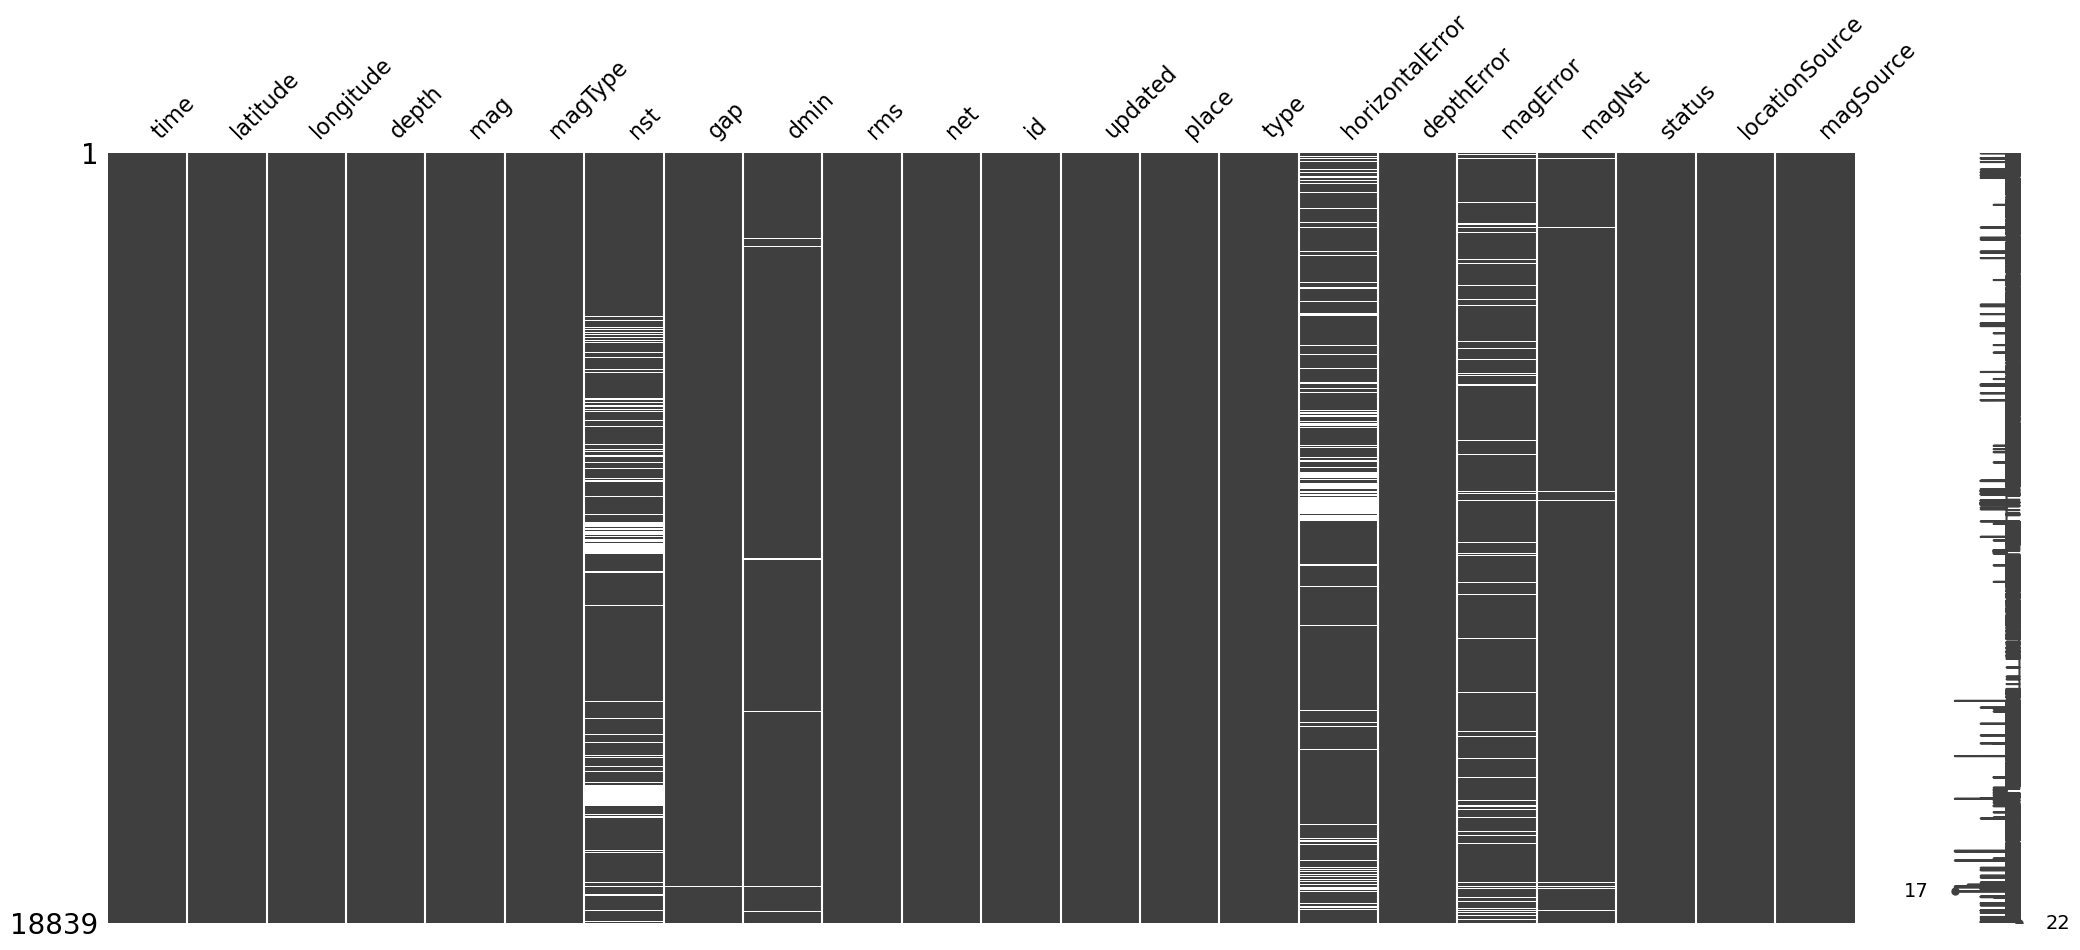

In [503]:
msn.matrix(df)

### *Completeness magnitude*

Before we begin, we must determine what is called a "completeness magnitude" for our catalog of earthquake data. This is the minimum magnitude above which all earthquakes within a certain region are reliably recorded. There are many ways to determine the completeness magnitude, such as the Method of Maximum Curvature, the KS distance method (goodness-of-fit test), and b-value stability method. In this project, we will use the b-value stability method [5]. This is how it works: 

1. Loop through candidate values $M^i_{min}$ starting from a low threshold (e.g 2.0) up to some upper limit (e.g. 4.5) with a step size like 0.1.  
2. For each M_{min}^{i} take only magnitudes $M\geq M^i_{min}$ and estimate the b-value, usually with MLE (more on that later). 
3. Find the candidate value where the b-value across a range L remains within its theoretical standard deviaton $\sigma_b$

Mathematically denoted, $M_c$ by b-value stability is defined as:  

$$M_c = min(M_i|abs(\frac{L}{\Delta M} \sum^{M_i + L}_{M_j=M_i + \Delta M} b(M_j) - b(M_i)) \lt \sigma_b{(M_i)} )$$  

Where $\Delta M$ is the magnitude bin size (0.1 in our case), and $L$ is a stability range, set to 0.5 by default.  


In [504]:
mags = df[df['mag']>0]['mag']

cat = Catalog.from_dict({
    'magnitude': mags})

cat.delta_m = 0.01
cat = cat.bin_magnitudes()


In [505]:
res = cat.estimate_mc_b_stability()

return_vals: {'best_b_value': 0.9031452940475485, 'mcs_tested': [2.5, 2.51, 2.52], 'b_values_tested': [0.9508718842348276, 0.8981177156164152, 0.9031452940475485], 'diff_bs': [5.722500648722627, 1.607548033283654, 0.7071952304272405]}


In [506]:
Mc = res[0]
print(f"Estimated completeness magnitude: {Mc}")

Estimated completeness magnitude: 2.52


Since our magnitude of completeness was calculated to be 2.52, we will only consider magnitudes greater than or equal to it. 

In [507]:
drop_columns = ["nst", "gap", "dmin", "rms", "horizontalError", "depthError", "magError", "magNst"]
df.drop(columns = drop_columns, inplace = True)

df = df[df['mag'] >= Mc]

### *EDA and Visualization*

##### *General histogram of earthquake magnitudes*

<Axes: xlabel='mag', ylabel='Count'>

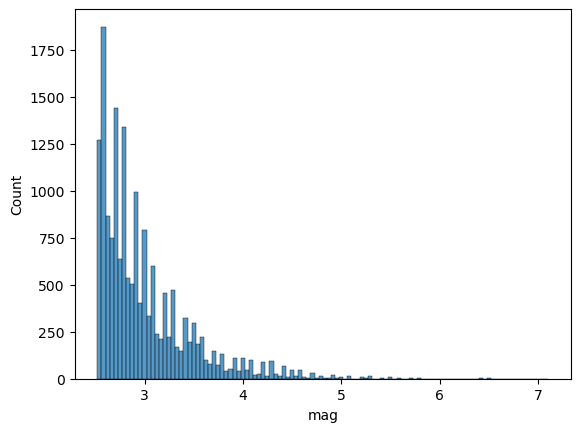

In [508]:
magnitudes = df["mag"] 
sns.histplot(magnitudes) 

##### *Empirical Gutenberg-Richter plot*

In [509]:
bins = [i for i in range(2,8)]  

M_vals = np.linspace(start=Mc, stop=7, num=1000)
M_indices = [i for i in range(len(M_vals))]
counts = [0] * len(M_indices)

j=0 
for M in M_vals:
    for magnitude in magnitudes:
        if magnitude >= M: 
            counts[j] += 1 
    j+=1   


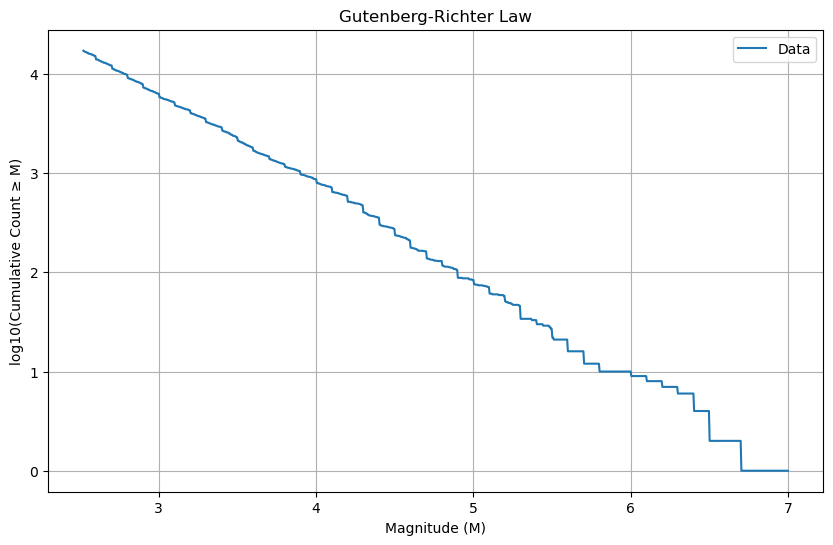

In [510]:
plt.figure(figsize=(10,6))
plt.plot(M_vals, np.log10(counts), label='Data')
plt.xlabel('Magnitude (M)')
plt.ylabel('log10(Cumulative Count ≥ M)')
plt.title('Gutenberg-Richter Law')
plt.grid(True)
plt.legend()
plt.show()

#### *Survival function (CCDF)*

The survival function $S(x)$ - also known as the complementary cumulative distribution function (CCDF), gives the probability that a random variable $X$ takes on a value greater than x: 

$$S(x) = P (X > x) = 1 - F(x)$$

Where $F(x)$ is the cumulative distribution function (CDF) of $X$. For magnitudes $M$, the survival function tells us  

$$S(M_0) = P(M > M_0)$$  

Or the probability that a randomly selected magnitude $M$ is larger than $M_0$. This is exactly what the Gutenberg-Richter law describes, since:  

$$\log_{10}N(M) = a - bM \rightarrow N(M) = 10^{a-bM}$$  

so 

$$S(M) \propto 10^{-bM} = e^{-b\ln(10)M}$$ 

Thus, plotting the survival function for a given catalog of earthquakes gives us its empirical Gutenberg-Richter behavior.  



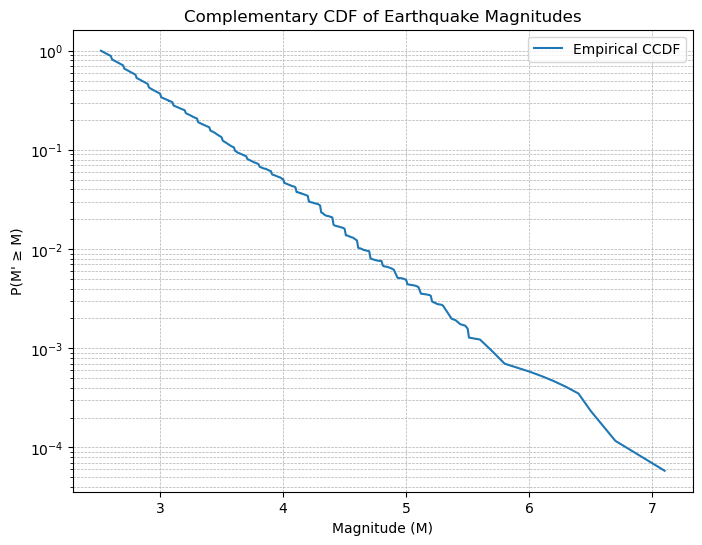

In [511]:
import numpy as np
import matplotlib.pyplot as plt

magnitudes = np.sort(magnitudes)

ccdf = np.array([np.sum(magnitudes >= m) / len(magnitudes) for m in magnitudes])

plt.figure(figsize=(8, 6))
plt.plot(magnitudes, ccdf, linestyle="solid", label='Empirical CCDF')
plt.yscale('log')  
plt.xlabel("Magnitude (M)")
plt.ylabel("P(M' ≥ M)")
plt.title("Complementary CDF of Earthquake Magnitudes")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

### *Statistical Modeling: estimating the b-value in the formula*

##### *Aki's MLE estimator* 
 
 Aki's classic estimator [2] models earthquake magnitudes as a continuous random variable following an exponential distribuiton. The above histogram of the frequencies of earthquakes by magnitudes certainly justifies this assumtion for our data. This approach also assumes a *completenes threshold* - a minimum earthquake magnitude above which we believe all earthquakes are recorded reliably. In this project, we will assume this value is 2.5. Firstly, let us acknowledge that:  

 $\log_{10} N = a - bM $   
 $N = 10^{a - bM} = 10^a \cdot 10^{-bM}$  
 $N \propto 10^{-bM}$

 In order to model earthquake magintudes as exponentially distributed random variables, we will need to convert to an expression in base-$e$, so we have  

 $$10^{-bM} = e^{-bM\cdot \ln(10)}, \text{ and for convenience we will define } \beta = b \cdot \ln(10) $$  

Let $M \geq M_{min}$ be the magnitude. We assume the magnitudes follow: 

$$f(M;\beta) = \beta e^{-\beta(M-M_{min})}$$  


Given n independent observations $M_1, M_2, ..., M_n$, the likelihood is:  

$$L(\beta) = \prod_{i=1}^{n} \beta e^{{-\beta(M_i-M_{min})}} = \beta^n e ^{ - \beta \sum_{i=1}^{n}(M_i - M_{min})}$$  

Taking the log of the likelihood function gives us: 

$$\log L(\beta) = n \log \beta - \beta \sum_{i=1}^{n} (M_i - M_{min})$$  

Taking the derivative of the log-likelihood with respect to $\beta$:  

$$\frac{d}{d\beta} \log L(B) = \frac{n}{\beta} - \sum_{i=1}^{n} (M_i - M_{min}) $$  

Setting the derivative equal to zero, and solving for $\hat{\beta}$  

$$\frac{n}{\hat{\beta}} = \sum_{i=1}^{n}$$  
$$\hat{\beta} = \frac{n}{\sum_{i=1}^{n}(M_i - M_{min})}$$  

We can substitute the denominator with $n \cdot (\overline{M} - M_{min})$, and we finally get 


$$\beta = \frac{1}{\overline{M} - M_{min}}$$  

Recall that $\beta = b \cdot \ln (10) $, so our final estimate for $b$ becomes:  

$$\hat{b} = \frac{1}{\ln(10)\cdot(\overline{M} - M_{min})} $$


Note that in the following estimation of $b$ as per our derived formula, is the exact same one returned from the built in function from SeismoStats, where we estimated the . 


In [512]:
import numpy as np

M_min = Mc 
M = magnitudes[magnitudes >= M_min]

mean_mag = np.mean(M)
b_mle = 1 / (np.log(10) * (mean_mag - M_min))
print(f"MLE estimate of b: {b_mle:.4f}")

MLE estimate of b: 0.9126


Comparing the fitted exponential PDF to the histogram of our data.

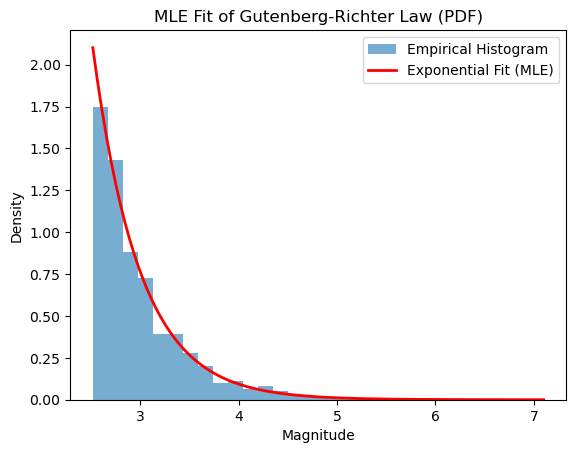

In [513]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

Mmin = Mc
beta_mle = b_mle * np.log(10)


plt.hist(magnitudes, bins=30, density=True, alpha=0.6, label="Empirical Histogram")

x = np.linspace(Mmin, magnitudes.max(), 200)
pdf = beta_mle * np.exp(-beta_mle * (x - Mmin))
plt.plot(x, pdf, 'r-', lw=2, label=f"Exponential Fit (MLE)")

plt.xlabel("Magnitude")
plt.ylabel("Density")
plt.title("MLE Fit of Gutenberg-Richter Law (PDF)")
plt.legend()
plt.show()


Comparing the CCDF of our data vs with our fitted b value.

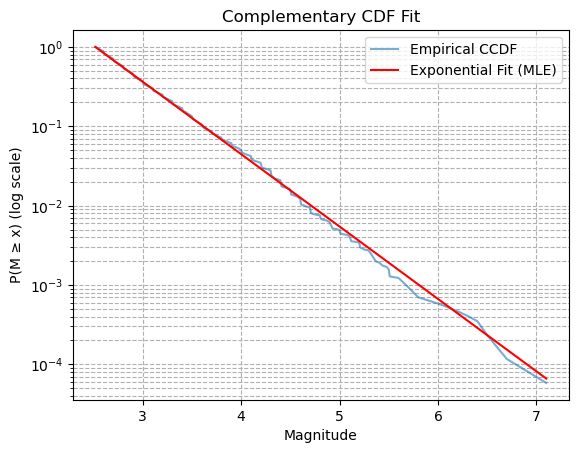

In [514]:
sorted_mags = np.sort(magnitudes)
ccdf_empirical = np.array([np.sum(magnitudes >= m) / len(magnitudes) for m in magnitudes])
ccdf_theoretical = np.exp(-beta_mle * (sorted_mags - Mmin))

plt.plot(sorted_mags, ccdf_empirical, label="Empirical CCDF",  linestyle='solid', alpha=0.6)
plt.plot(sorted_mags, ccdf_theoretical, label="Exponential Fit (MLE)", color='r')

plt.yscale('log')
plt.xlabel("Magnitude")
plt.ylabel("P(M ≥ x) (log scale)")
plt.title("Complementary CDF Fit")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


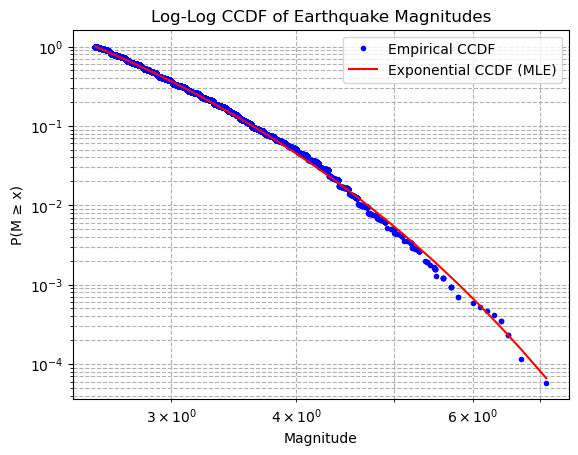

In [515]:
plt.loglog(sorted_mags, ccdf_empirical, 'b.', label="Empirical CCDF")
plt.loglog(sorted_mags, ccdf_theoretical, 'r-', label="Exponential CCDF (MLE)")
plt.xlabel("Magnitude")
plt.ylabel("P(M ≥ x)")
plt.title("Log-Log CCDF of Earthquake Magnitudes")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

While the exponential model provides a theoretically justified fit (per the Gutenberg–Richter law), the Kolmogorov–Smirnov test revealed enough deviation between the observed and predicted distributions to justify a low p-value (K–S statistic = 0.0396, p-value ≈ 0), suggesting that the model may not fully capture the statistical properties of the dataset.

In [516]:
from scipy.stats import kstest

D, p_value = kstest(magnitudes, lambda x: expon.cdf(x, loc=Mmin, scale=1/beta_mle))
print(f"K-S Statistic: {D:.4f}, p-value: {p_value:.4f}")

K-S Statistic: 0.0396, p-value: 0.0000


##### *Bayesial approach* 
Yaghmaei-Sabegh et al. [3] propose a Bayesian approach to estimating the b-parameter. We will retain our exponential assumption when deriving the likelihood function for the data, but we will introduce a Gamma prior for our $\beta$ parameter. Note: due to the ambiguity of the $\beta$ parameter analyised in the context of the Gutenberg-Richter law and the one used as a parameter in the gamma distribution in most literature, this text will use unconventional notation - denoting $\alpha$ and $\beta$ of the gamma distribution as $k$ and $\lambda$, respectivelly.  

First, for our beta prior we have  


$$p(\beta) = \frac{\lambda^k}{\Gamma(k)} \beta^{k-1} e^{-\lambda \beta}$$  

Using the same likelihood function as before, we can derive the posterior as follows: 



$$
p(\beta \mid \bold{m}) \propto p(\bold{m} \mid \beta) p(\beta)$$     
$$\propto \underbrace{\beta^n e^{-\beta S}}_{Likelihood} \cdot \underbrace{\beta^{k-1} e^{-\lambda \beta}}_{Prior}$$ 
$$\propto \beta^{n + k - 1} e^{-\beta (S + \lambda)},$$ 



where $\bold{m}$ is our data and  $S = \sum_{i=1}^{n}(M_{i} - M_{min} )$. Note that this is a gamma distribution given with  

$$\beta \mid \bold{m} \sim \Gamma(k + n, \lambda + S)$$  


Then $b$ is recovered by:  

$$b = \frac{\beta}{ln(10)}$$

Posterior shape (k): 16892.000
Posterior rate (lambda): 8169.540
Posterior mean of beta: 2.06768
Posterior mean of b-value: 0.89798


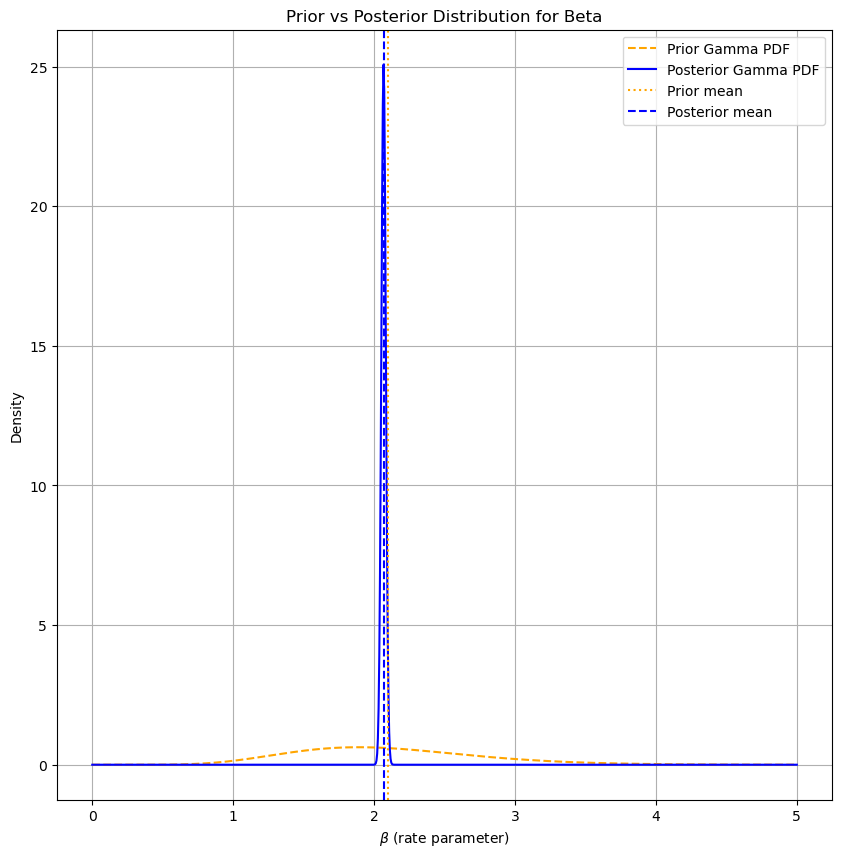

In [517]:
import numpy as np
from scipy.stats import gamma

M = magnitudes  
Mmin = Mc       

X = M - Mmin
X = X[X > 0]  
n = len(X)
S = X.sum()

beta_mle = b_mle * np.log(10)  

k_prior = 10
lambda_prior = k_prior / beta_mle


k_post = k_prior + n
lambda_post = lambda_prior + S

beta_post_mean = k_post / lambda_post

b_post_mean = beta_post_mean / np.log(10)

print(f"Posterior shape (k): {k_post:.3f}")
print(f"Posterior rate (lambda): {lambda_post:.3f}")
print(f"Posterior mean of beta: {beta_post_mean:.5f}")
print(f"Posterior mean of b-value: {b_post_mean:.5f}")

# Beta values range for smooth plot
beta_vals = np.linspace(0, 5, 1000)

# Calculate PDFs
prior_pdf = gamma.pdf(beta_vals, a=k_prior, scale=1/lambda_prior)
posterior_pdf = gamma.pdf(beta_vals, a=k_post, scale=1/lambda_post)

# Plot
plt.figure(figsize=(10,10))
plt.plot(beta_vals, prior_pdf, label='Prior Gamma PDF', linestyle='--', color='orange')
plt.plot(beta_vals, posterior_pdf, label='Posterior Gamma PDF', color='blue')
plt.axvline(k_prior / lambda_prior, color='orange', linestyle=':', label='Prior mean')
plt.axvline(k_post / lambda_post, color='blue', linestyle='--', label='Posterior mean')
plt.xlabel(r'$\beta$ (rate parameter)')
plt.ylabel('Density')
plt.title('Prior vs Posterior Distribution for Beta')
plt.legend()
plt.grid(True)
plt.show()

The posterior mean is 0.89, which barely differs from the previous estimate, let us inspect the the histogram-to-fit, CCDF and log-log plots. 

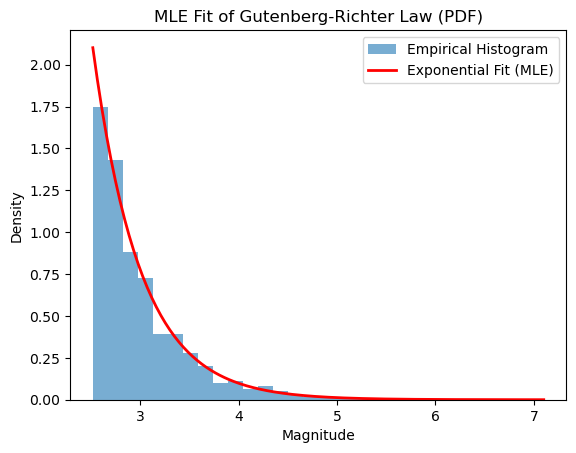

In [518]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

Mmin = Mc


plt.hist(magnitudes, bins=30, density=True, alpha=0.6, label="Empirical Histogram")

x = np.linspace(Mmin, magnitudes.max(), 200)
pdf = beta_mle * np.exp(-beta_post_mean * (x - Mmin))
plt.plot(x, pdf, 'r-', lw=2, label=f"Exponential Fit (MLE)")

plt.xlabel("Magnitude")
plt.ylabel("Density")
plt.title("MLE Fit of Gutenberg-Richter Law (PDF)")
plt.legend()
plt.show()

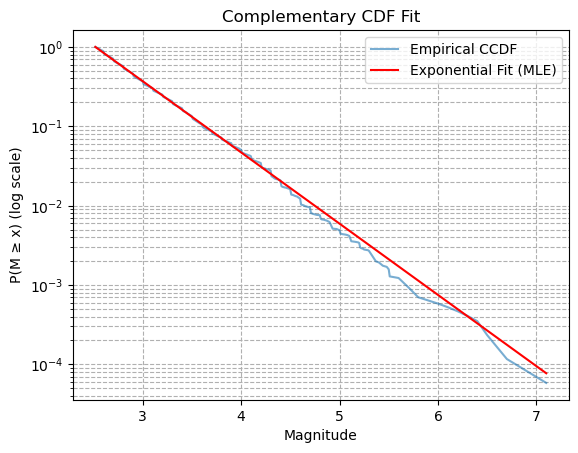

In [519]:
sorted_mags = np.sort(magnitudes)
ccdf_empirical = np.array([np.sum(magnitudes >= m) / len(magnitudes) for m in magnitudes])
ccdf_theoretical = np.exp(-beta_post_mean * (sorted_mags - Mmin))

plt.plot(sorted_mags, ccdf_empirical, label="Empirical CCDF",  linestyle='solid', alpha=0.6)
plt.plot(sorted_mags, ccdf_theoretical, label="Exponential Fit (MLE)", color='r')

plt.yscale('log')
plt.xlabel("Magnitude")
plt.ylabel("P(M ≥ x) (log scale)")
plt.title("Complementary CDF Fit")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

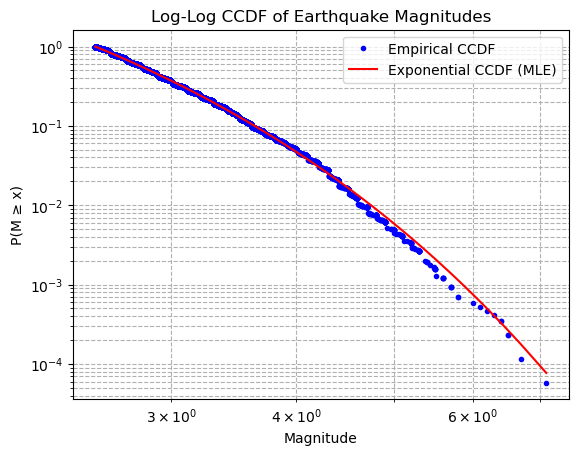

In [520]:
plt.loglog(sorted_mags, ccdf_empirical, 'b.', label="Empirical CCDF")
plt.loglog(sorted_mags, ccdf_theoretical, 'r-', label="Exponential CCDF (MLE)")
plt.xlabel("Magnitude")
plt.ylabel("P(M ≥ x)")
plt.title("Log-Log CCDF of Earthquake Magnitudes")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

As expected, the fit is practically identical to the previous one. It seems unlikely that a KS test will lead to accepting the hypothesis of our data following the calculated distribution.

In [521]:
from scipy.stats import kstest

D, p_value = kstest(magnitudes, lambda x: expon.cdf(x, loc=Mmin, scale=1/beta_post_mean))
print(f"K-S Statistic: {D:.4f}, p-value: {p_value:.4f}")

K-S Statistic: 0.0373, p-value: 0.0000


The KS statistic shows a slightly smaller gap between the two distributions, but not one small enough to justify an accepting of the null hypothesis.

#### *Extreme Value Theory Analysis*

In this part of the project, we will analyize the tails of earthquake distributions.
 

We will perform the same preprocessing steps on the data, except we will use data gathered from Japan. 

<Axes: xlabel='mag', ylabel='Count'>

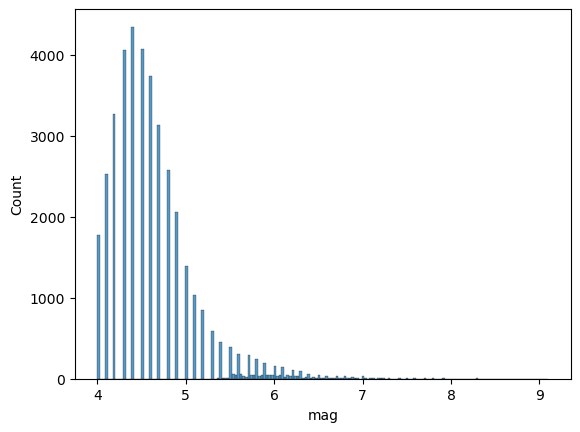

In [522]:
df_1 = pd.read_csv("data/japan_1.csv")
df_2 = pd.read_csv("data/japan_2.csv")


df = pd.concat([df_1,df_2], axis=0)
df.sample(3)


df["time"] = pd.to_datetime(df["time"]) 
df.drop_duplicates(inplace=True)

drop_columns = ["nst", "gap", "dmin", "rms", "horizontalError", "depthError", "magError", "magNst"]
df.drop(columns = drop_columns, inplace = True)

magnitudes = df["mag"] 
sns.histplot(magnitudes) 

 As evident in the histogram, Japan (unfortunatelly) experiences a high frequency of high-magnitude earthquakes, making the data suitable candidate for EVT analysis.

##### *General extreme value (GEV) distribution* 

The Generalized Extreme Value (GEV) [4] distribution is a fundamental model in Extreme Value Theory (EVT) used to describe the behavior of the maximum (or minimum) values drawn from a large collection of independent and identically distributed (i.i.d.) random variables.

The GEV distribution unifies three types of extreme value distributions into one family:  

$$G(z) = \exp{\{-[1+\xi(\frac{z-\mu}{\sigma})]^{\frac{-1}{\xi}}\}}$$  


$\mu$: Roughly, the typical value of the maximum magnitude in a block (e.g., average yearly maximum magnitude).

$\sigma$: How much variability there is in those maxima.

Shape $\xi$: Determines the tail behavior:

$\xi>0$ (Fréchet): Heavy tail, higher chance of extremely large earthquakes beyond observed max.

$\xi=0$ (Gumbel): Light tail, exponential decay, extreme values thin out quickly.

$\xi<0$ (Weibull): Bounded tail, theoretical maximum earthquake magnitude.

We will attempt to capture the probabilistic behavior of the largest earthquakes in Japan from 2015 to 2025. We will divide the data into one-month long blocks and sample the maximum earthquake magnitude in each month.  

GEV shape: -0.136, location: 6.948, scale: 0.509


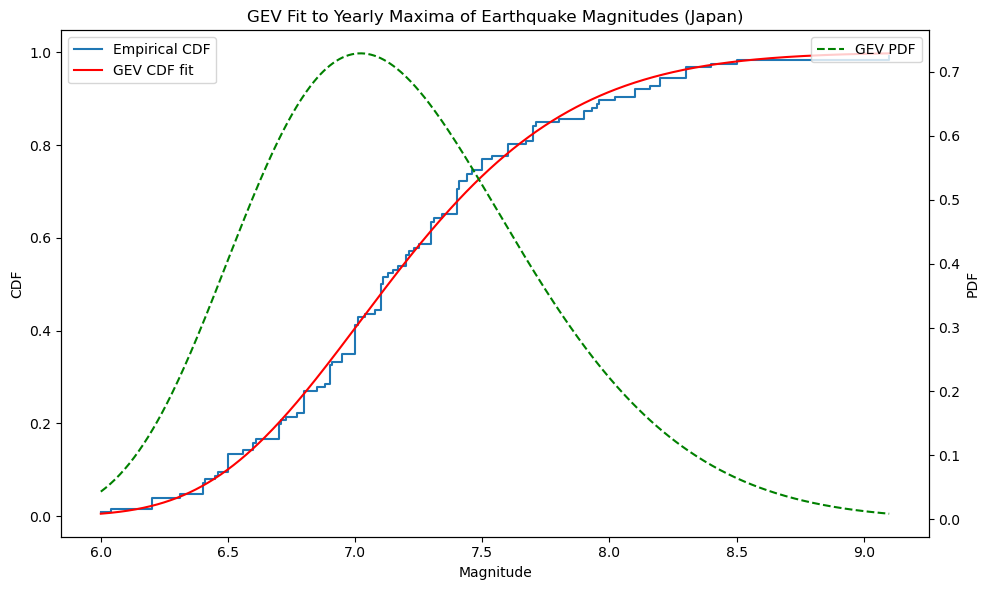

In [523]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genextreme


df['year'] = df['time'].dt.year
yearly_max = df.groupby('year')['mag'].max()

params = genextreme.fit(yearly_max)
c, loc, scale = params
print(f"GEV shape: {-c:.3f}, location: {loc:.3f}, scale: {scale:.3f}")

x = np.linspace(min(yearly_max), max(yearly_max), 500)

cdf_empirical = np.arange(1, len(yearly_max) + 1) / (len(yearly_max) + 1)

cdf_fitted = genextreme.cdf(x, c, loc=loc, scale=scale)
pdf_fitted = genextreme.pdf(x, c, loc=loc, scale=scale)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.step(np.sort(yearly_max), cdf_empirical, where='post', label='Empirical CDF')

ax1.plot(x, cdf_fitted, 'r-', label='GEV CDF fit')

ax1.set_xlabel("Magnitude")
ax1.set_ylabel("CDF")
ax1.legend(loc='upper left')
ax1.set_title("GEV Fit to Yearly Maxima of Earthquake Magnitudes (Japan)")

ax2 = ax1.twinx()
ax2.plot(x, pdf_fitted, 'g--', label='GEV PDF')
ax2.set_ylabel("PDF")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


##### *Return levels* [4]

Suppose we model the annual maxima of earthquake magnitudes using a GEV distribution with parameters shape $\xi$, location $\mu$, and scale $\sigma$.

The return level $z_T$ for a return period $T$ (in years) is the quantile that satisfies:  

$$P(X>z_T) = \frac{1}{T}$$

Simply put, we are looking for the magnitude that we expect to see once in T years. Since the CDF at $z_T$ is 

$$F(z_T) = 1 - \frac{1}{T}$$

Since F is the CDF of the GEV, the return value is found by inverting the CDF:  

$$z_T = F^{-1}(1-\frac{1}{T})$$  

Some math later, reveals the expression:  

$$z_T = \mu - \frac{\sigma}{\xi} [1 - \{-\log(1-\frac{1}{T})\}^{-\xi}] $$  



Below, we can see the calculated return levels for 10, 20, 30, 50 and 100 years.

10-year return level: 7.936
20-year return level: 8.193
30-year return level: 8.330
50-year return level: 8.491
100-year return level: 8.690


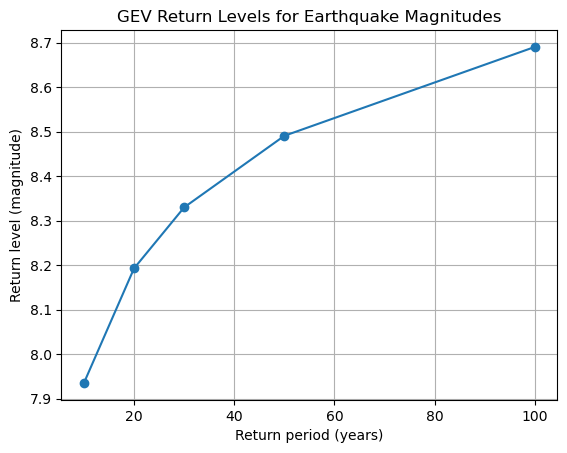

In [524]:
from scipy.stats import genextreme


return_periods = [10, 20, 30, 50, 100]  

return_levels = []

for T in return_periods:
    p = 1 - 1/T
    z_T = genextreme.ppf(p, c, loc=loc, scale=scale)
    return_levels.append(z_T)
    print(f"{T}-year return level: {z_T:.3f}")


plt.plot(return_periods, return_levels, marker='o')
plt.xlabel("Return period (years)")
plt.ylabel("Return level (magnitude)")
plt.title("GEV Return Levels for Earthquake Magnitudes")
plt.grid(True)
plt.show()

##### *Return periods*

Since we have a fitted GEV distribution, we can also calculate the average number of years expected to pass before observing an event exceeding a specific threshold $z$. This way, we can quantify how rare a certain earthquake magnitude is, using years.  

given a fitted GEV cumulative distribution function $F(z)$, the return period $T(z)$ is computed as: 

$$T(z) = \frac{1}{1 - F(z)}$$



Return period for M: 7.1 - 1.9 years
Return period for M: 8.2 - 20.4 years
Return period for M: 9.1 - 535.3 years


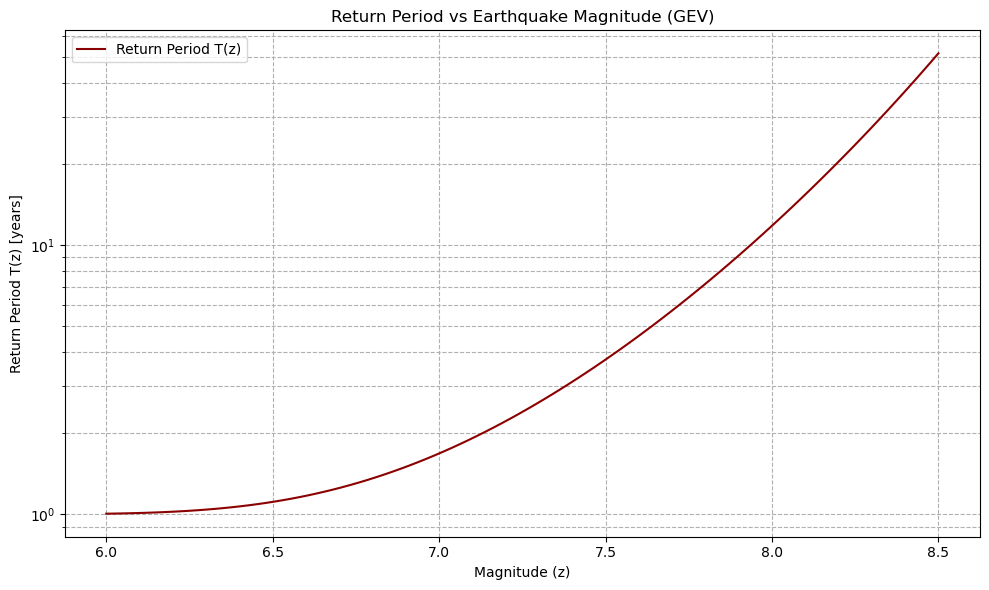

In [525]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme

# Example GEV parameters (change to your fitted values!)
# c = shape, loc = location, scale = scale

# Generate a range of magnitudes (z)
z = np.linspace(6.0, 8.5, 100)

# Compute CDF
F_z = genextreme.cdf(z, c=c, loc=loc, scale=scale)

zs = [7.1, 8.2, 9.1]
Fz = genextreme.cdf(zs, c=c, loc=loc, scale=scale)

for p,zz in zip(Fz, zs):
    Tz = 1 / (1 - p)
    print(f"Return period for M: {zz} - {Tz:.1f} years")

# Compute Return Period T(z)
T_z = 1 / (1 - F_z)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(z, T_z, label='Return Period T(z)', color='darkred')
plt.yscale('log')  # Use log scale for better visibility
plt.xlabel('Magnitude (z)')
plt.ylabel('Return Period T(z) [years]')
plt.title('Return Period vs Earthquake Magnitude (GEV)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

##### *Tail risk estimation*

We can also calculate the probability that an extreme event exceeding a certain magnitude will occur within a given time frame. Let  

$z$ - a threshold magnitude  
$F(z)$ - CDF of the fitted GEV distribution  
$T(z) = \frac{1}{1 - f(Z)}$ - return period   
$t$ - number of years in the future  

Then the probability of at least one earthquake of magnitue $\geq z$ in the next $t$ years is:  

$$1 - (1 - \frac{1}{T(z)})^t $$




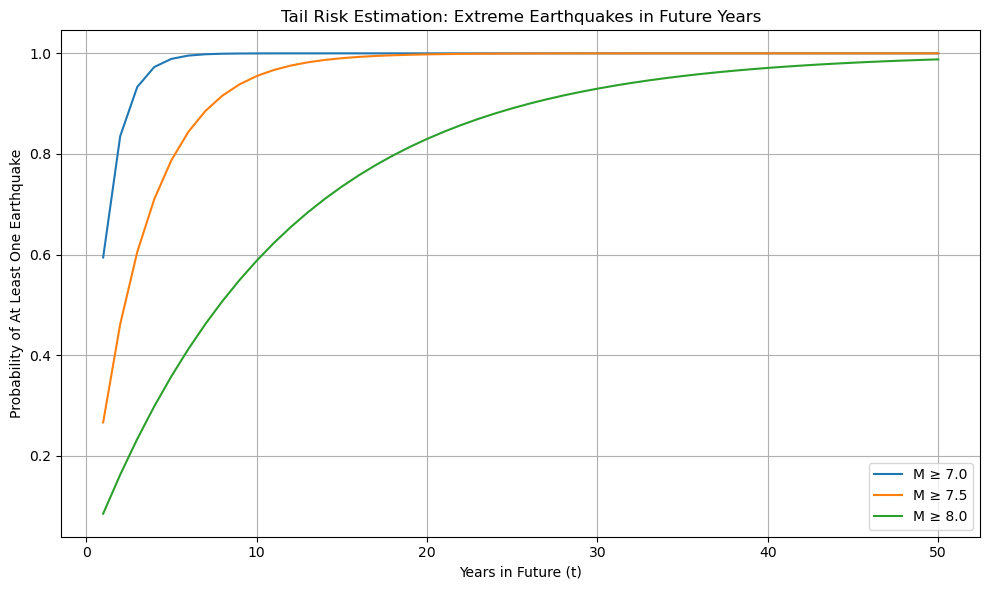

In [526]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme

# GEV parameters (from your Japan fit)

# Define thresholds (magnitudes to evaluate tail risk for)
z_vals = [7.0, 7.5, 8.0]

# Time frame (years into the future)
t = np.arange(1, 51)  # 1 to 50 years

plt.figure(figsize=(10, 6))

for z in z_vals:
    # Return period T(z)
    F_z = genextreme.cdf(z, c=c, loc=loc, scale=scale)
    P_exceed_in_t_years = 1 - F_z**t  # Tail risk

    plt.plot(t, P_exceed_in_t_years, label=f'M ≥ {z}')

plt.xlabel('Years in Future (t)')
plt.ylabel('Probability of At Least One Earthquake')
plt.title('Tail Risk Estimation: Extreme Earthquakes in Future Years')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

##### *Generalized Pareto Distribution (GPD) and Peak-over-threshold (POT) analysis* 

The Peak Over Threshold-method (POT-method) is one way to model extreme
values. The main concept of the method is to use a threshold to seclude values
considered extreme to the rest of the data and create a model for the extreme values
by modeling the tail of all the values the exceeds this threshold. This is done in
practice by setting a threshold u to be some value defined on R that exceeds most
but not all values defined in some time series or some other vector of collected
values. Furthermore it can be shown that for some sufficiently large threshold u the
distribution of the values exceeding the threshold approximate to a General Pareto
Distribution with some Shape and Scale parameter.



Threshold u: 7.00
Number of exceedances: 131


GPD shape (xi): -0.123, scale (sigma): 0.478


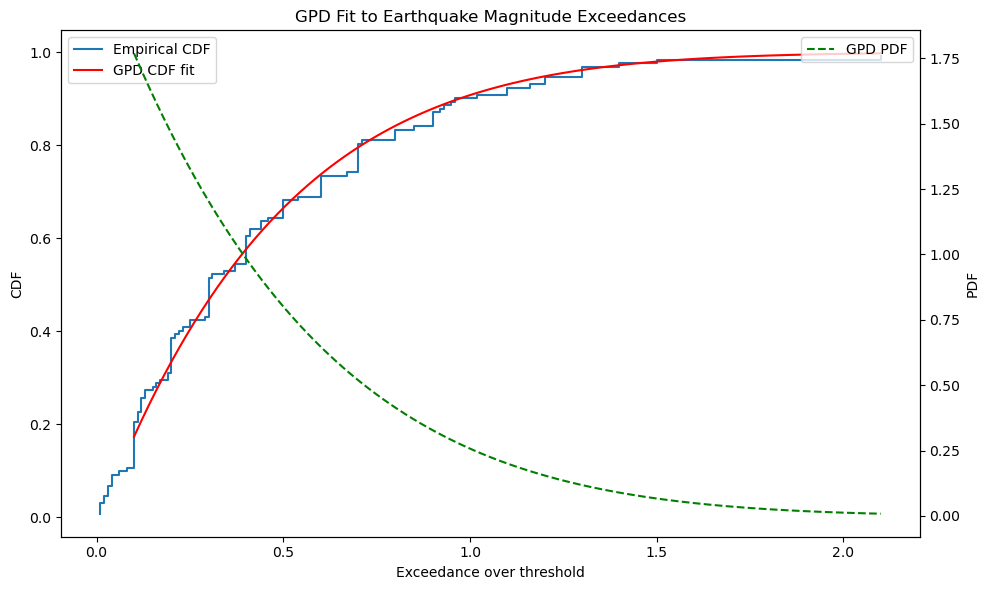

In [527]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto

magnitudes = df['mag']

u = 7
exceedances = magnitudes[magnitudes > u] - u  

print(f"Threshold u: {u:.2f}")
print(f"Number of exceedances: {len(exceedances)}")

params = genpareto.fit(exceedances)
c, loc, scale = params
print(f"GPD shape (xi): {c:.3f}, scale (sigma): {scale:.3f}")

x = np.linspace(0.1, max(exceedances), 100)
cdf_empirical = np.arange(1, len(exceedances) + 1) / (len(exceedances) + 1)
cdf_fitted = genpareto.cdf(x, c, loc=loc, scale=scale)
pdf_fitted = genpareto.pdf(x, c, loc=loc, scale=scale)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.step(np.sort(exceedances), cdf_empirical, label='Empirical CDF', where='post')
ax1.plot(x, cdf_fitted, label='GPD CDF fit', color='red')
ax1.set_xlabel("Exceedance over threshold")
ax1.set_ylabel("CDF")
ax1.legend(loc='upper left')
ax1.set_title("GPD Fit to Earthquake Magnitude Exceedances")


ax2 = ax1.twinx()
ax2.plot(x, pdf_fitted, label='GPD PDF', color='green', linestyle='--')
ax2.set_ylabel("PDF")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


#### *References*
[1] - Gutenberg, B., and C. F. Richter (1944). Frequency of earthquakes in
California, Bull. Seismol. Soc. Am. 34  
[2] - Aki, K. (1965). Maximum likelihood estimate of b in the formula log N =
a - bM and its confidence limits, Bull. Earthq. Res. Inst. Tokyo Univ.
43  
[3] - Yaghmaei-Sabegh, S., Ostadi-Asl, G. Bayesian estimation of b-value in Gutenberg–Richter relationship: a sample size reduction approach. Nat Hazards 110, 1783–1797 (2022). https://doi.org/10.1007/s11069-021-05012-0  
[4] - Stuart Coles. An introduction to statistical modeling of extreme values. Springer Series in Statistics. Springer, London, England, 2001 edition, August 2001. ISBN 978-1-85233-459-8. URL: https://doi.org/10.1007/978-1-4471-3675-0.  
[5] - Cao, Aimin, and Stephen S. Gao. "Temporal variation of seismic b‐values beneath northeastern Japan island arc." Geophysical research letters 29.9 (2002): 48-1.